In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 22 11:30:30 2017

@author: thomas
"""

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import openFOAM_FINAL as foam
import os
import sys
sys.path.append("..")
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("..")

#home = os.path.realpath('MinorCSE') + '/'
home = '/home/thomas/Documents/minor-project-turbulence/MinorCSE' + '/'

##################################################################################################################
######################################### Loading the RANS data ##################################################
##################################################################################################################
def RANS(case, Re, TurbModel, time_end, nx, ny):
    dir_RANS  = home + ('%s' % case) + '/' + ('Re%i_%s' % (Re,TurbModel))
    if case == 'SquareDuct':
        dir_RANS = dir_RANS + '_50'
        if Re > 2000:
            time_end = 50000
            
    if case == 'ConvergingDivergingChannel':
        dir_RANS = dir_RANS + '_100'
        
    mesh_list  = foam.getRANSVector(dir_RANS, time_end, 'cellCentres')
    mesh      = foam.getRANSPlane(mesh_list,'2D', nx, ny, 'vector')
    #velocity
    U_list    = foam.getRANSVector(dir_RANS, time_end, 'U')
    U        = foam.getRANSPlane(U_list,'2D', nx, ny, 'vector')
    #velocity gradient
    gradU_list  = foam.getRANSTensor(dir_RANS, time_end, 'grad(U)')
    gradU      = foam.getRANSPlane(gradU_list,'2D', nx, ny, 'tensor')
    #pressure
    p_list    = foam.getRANSScalar(dir_RANS, time_end, 'p')
    p        = foam.getRANSPlane(p_list,'2D', nx, ny, 'scalar')
    #pressure gradient
    gradp_list    = foam.getRANSVector(dir_RANS, time_end, 'grad(p)')
    gradp        = foam.getRANSPlane(gradp_list,'2D', nx, ny, 'vector')
    #Reynolds stress tensor
    tau_list  = foam.getRANSSymmTensor(dir_RANS, time_end, 'R')
    tau      = foam.getRANSPlane(tau_list,'2D', nx, ny, 'tensor')
    #k
    k_list    = foam.getRANSScalar(dir_RANS, time_end, 'k')
    k        = foam.getRANSPlane(k_list,'2D', nx, ny, 'scalar')
    #k gradient
    gradk_list    = foam.getRANSVector(dir_RANS, time_end, 'grad(k)')
    gradk        = foam.getRANSPlane(gradk_list,'2D', nx, ny, 'vector')
    #distance to wall
    yWall_list = foam.getRANSScalar(dir_RANS, time_end, 'yWall')
    yWall        = foam.getRANSPlane(yWall_list,'2D', nx, ny, 'scalar')
    #omega
    omega_list  = foam.getRANSScalar(dir_RANS, time_end, 'omega')
    omega      = foam.getRANSPlane(omega_list, '2D', nx, ny, 'scalar')
    #S R tensor
    S, Omega  = foam.getSRTensors(gradU)
    
    return mesh, U, gradU, p, gradp, tau, k, gradk, yWall, omega, S, Omega

##################################################################################################################
######################################### Features  ##############################################################
##################################################################################################################
def q1(S, Omega): 
    a = np.shape(S)
    q1 = np.zeros((a[2],a[3]))
    for i1 in range(a[2]):
        for i2 in range(a[3]):               
            raw = 0.5*(np.abs(np.trace(np.dot(S[:,:,i1,i2],S[:,:,i1,i2]))) - np.abs(np.trace(np.dot(Omega[:,:,i1,i2],-1*(Omega[:,:,i1,i2])))))
            norm = np.trace(np.dot(S[:,:,i1,i2],S[:,:,i1,i2]))
            q1[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q1

def q2(k, U):
    a = np.shape(k)
    q2 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            raw = k[0,i1,i2]
            norm = 0.5*(np.inner(U[:, i1, i2], U[:, i1, i2])) # inner is equivalent to sum UiUi
            q2[i1,i2] = raw/(np.abs(raw) + np.abs(norm))
    return q2

    
def q3(k, yWall, nu=1.4285714285714286e-03):
    a = np.shape(k)
    q3 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):               
            q3[i1,i2] = np.minimum((np.sqrt(k[:,i1,i2][0])*yWall[:, i1, i2])/(50*nu), 2)
    return q3
    

def q4(U, gradP):
    a = np.shape(gradP)
    q4 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('k,k', U[:,i1,i2], gradP[:,i1,i2])
            norm = np.einsum('j,j,i,i', gradP[:,i1,i2], gradP[:,i1,i2], U[:, i1, i2],U[:, i1, i2])
            
            q4[i1,i2] = raw / (np.fabs(norm) + np.fabs(raw));
    return q4


def q5(k, S, omega, Cmu=0.09):
    a = np.shape(k)
    q5 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            epsilon = Cmu * k[:, i1, i2] * omega[:,i1,i2]
            raw = k[:,i1,i2] / epsilon
            norm = 1 / np.sqrt(np.trace(np.dot(S[:,:,i1,i2], S[:,:,i1,i2])))
            q5[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q5


def q6(gradP, gradU, p, U):
    a = np.shape(gradP)
    q6 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.sqrt(np.einsum('i,i', gradP[:,i1,i2], gradP[:,i1,i2]))
            norm = np.einsum('k, kk', U[:,i1,i2], gradU[:,:,i1,i2])
           
            norm *= 0.5 * p[0,i1,i2]
            q6[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q6
    

def q7(U, gradU):
    a = np.shape(U)
    q7 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.fabs(np.einsum('i, j, ij', U[:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2]))
            norm = np.sqrt(np.einsum('l, l, i, ij, k, kj', U[:,i1,i2], U[:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2], U[:,i1,i2], gradU[:,:,i1,i2]))
            q7[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q7



def q8(U, gradK, Tau, S):
    a = np.shape(U)
    q8 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):
            raw  = np.einsum('i,i', U[:,i1,i2], gradK[:,i1,i2])
            norm = np.einsum('jk,jk', Tau[:,:,i1,i2], S[:,:,i1,i2])
            q8[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))              
    return q8
  

def q9(tau, k):
    a = np.shape(k)
    q9 = np.zeros((a[1],a[2]))
    for i1 in range(a[1]):
        for i2 in range(a[2]):    
            raw = np.sqrt(np.trace(np.dot(tau[:,:,i1,i2], np.transpose(tau[:,:,i1,i2]))))
            norm = k[:,i1,i2]
            q9[i1,i2] = raw/(np.fabs(raw) + np.fabs(norm))
    return q9   

##################################################################################################################
######################################### Feature function #######################################################
##################################################################################################################
    
def features(case, Re, TurbModel, time_end, nx, ny):
    X = np.zeros((nx*len(Re) * ny, 9))
    
    for i in range(len(Re)):
        meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re[i], TurbModel, time_end, nx, ny)
        feature = np.zeros((9, nx, ny))
        feature[0,:,:] = q1(S_RANS, Omega_RANS)
        feature[1,:,:] = q2(k_RANS, U_RANS)
        feature[2,:,:] = q3(k_RANS, yWall_RANS)
        feature[3,:,:] = q4(U_RANS, gradp_RANS)
        feature[4,:,:] = q5(k_RANS, S_RANS, omega_RANS)
        feature[5,:,:] = q6(gradp_RANS, gradU_RANS, p_RANS,U_RANS)
        feature[6,:,:] = q7(U_RANS, gradU_RANS)
        feature[7,:,:] = q8(U_RANS, gradk_RANS, tau_RANS, S_RANS)
        feature[8,:,:] = q9(tau_RANS, k_RANS)
        feature = np.reshape(feature.swapaxes(1,2), (nx*ny, 9), "F")
        feature = np.reshape(feature.swapaxes(1,0), (nx*ny, 9))
        X[i*nx*ny:(i+1)*nx*ny, :] = feature
    return X

### 1
case = 'PeriodicHills'
Re = [700, 1400, 2800, 5600, 10595]
TurbModel = 'kOmega'
time_end = 30000
nx = 140
ny = 150

'''
### 2
case = 'SquareDuct'
Re = [1800, 2000, 2200, 2400, 2600, 2900, 3200, 3500] 
TurbModel = 'kOmega'
time_end = 40000
nx = 50
ny = 50

 
### 3
case = 'ConvergingDivergingChannel'
Re = [12600] 
TurbModel = 'kOmega'
time_end = 7000
nx = 140
ny = 100
 '''


"\n### 2\ncase = 'SquareDuct'\nRe = [1800, 2000, 2200, 2400, 2600, 2900, 3200, 3500] \nTurbModel = 'kOmega'\ntime_end = 40000\nnx = 50\nny = 50\n\n \n### 3\ncase = 'ConvergingDivergingChannel'\nRe = [12600] \nTurbModel = 'kOmega'\ntime_end = 7000\nnx = 140\nny = 100\n "

In [2]:

meshRANS, U_RANS, gradU_RANS, p_RANS, gradp_RANS, tau_RANS, k_RANS, gradk_RANS, yWall_RANS, omega_RANS, S_RANS, Omega_RANS = RANS(case, Re[4], 'kOmega', time_end, nx, ny)
 
q1 =  q1(S_RANS, Omega_RANS)
q2 = q2(k_RANS,U_RANS)
q3 = q3(k_RANS, yWall_RANS)
q4 = q4(U_RANS, gradp_RANS)
q5 = q5(k_RANS, S_RANS, omega_RANS)
q6 = q6(gradp_RANS, gradU_RANS, p_RANS,U_RANS)
q7 = q7(U_RANS, gradU_RANS)
q8 = q8(U_RANS, gradk_RANS, tau_RANS, S_RANS)
q9 = q9(tau_RANS, k_RANS)

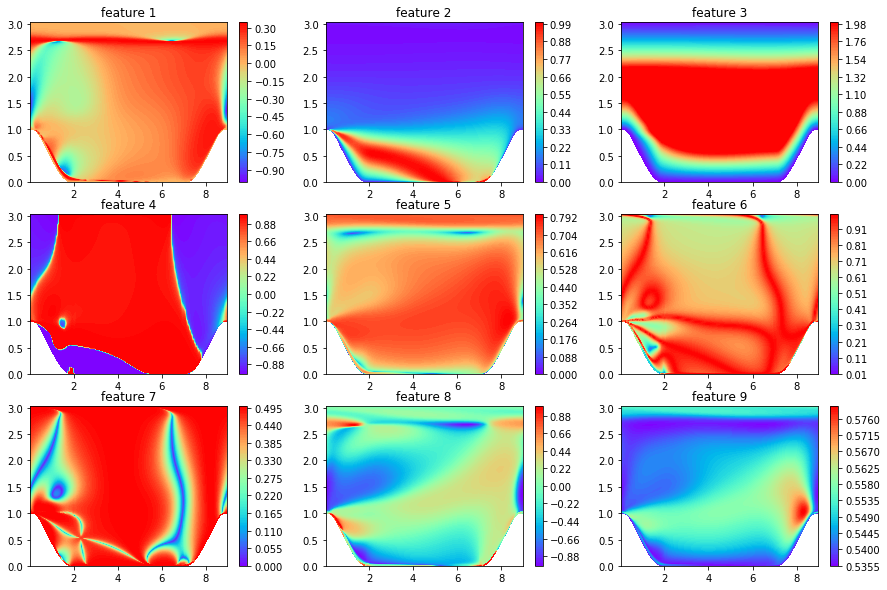

In [5]:
#cmap=plt.cm.coolwarm
#cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
#cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])



fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
list = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
for i in range(3):
    for j in range(3):
        im = axes[i,j].contourf(meshRANS[0,:,:], meshRANS[1,:,:], list[i*3+j], 100, cmap='rainbow')
        axes[i,j].set_title('feature %s' % str(i*3+j+1))
        fig.colorbar(im, ax = axes[i,j])

plt.show()

In [ ]:
#####################################################################################################################################################
#################################################### plot features #################################################################################

print(np.shape(meshRANS))

plt.figure()
plt.title("Feature 1")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q1(S_RANS, Omega_RANS))
plt.show()

plt.figure()
plt.title("Feature 2")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q2(k_RANS,U_RANS))
plt.show()

plt.figure()
plt.title("Feature 3")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q3(k_RANS, yWall_RANS))
plt.show()
 
plt.figure()
plt.title("Feature 4")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q4(U_RANS, gradp_RANS))
plt.show()

plt.figure()
plt.title("Feature 5")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q5(k_RANS, S_RANS, omega_RANS))
plt.show()

plt.figure()
plt.title("Feature 6")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q6(gradp_RANS, gradU_RANS, p_RANS,U_RANS))
plt.show()

plt.figure()
plt.title("Feature 7")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q7(U_RANS, gradU_RANS))
plt.show()


plt.figure()
plt.title("Feature 8")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q8(U_RANS, gradk_RANS, tau_RANS, S_RANS))
plt.show()

plt.figure()
plt.title("Feature 9")
plt.contourf(meshRANS[0,:,:], meshRANS[1,:,:], q9(tau_RANS, k_RANS))
plt.show()

